In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
# ----------------------------- helpers: file discovery -----------------------------
def _find_csvs(results_dir: str):
    all_csvs = sorted(glob.glob(os.path.join(results_dir, "*.csv")))
    main_csvs, bootstrap_csvs = [], []
    for fp in all_csvs:
        name = os.path.basename(fp).lower()
        if name.endswith("_bootstrap.csv"):
            bootstrap_csvs.append(fp)
        elif name.endswith("_top20_features.csv"):
            # ignore top-20 lists for plotting
            continue
        else:
            # consider as a main per-k CSV if it has "k" and ≥ 2 columns total
            try:
                head = pd.read_csv(fp, nrows=2)
                if "k" in head.columns and head.shape[1] >= 2:
                    main_csvs.append(fp)
            except Exception:
                pass
    return main_csvs, bootstrap_csvs

# ----------------------------- helpers: loading & merging -----------------------------
def _load_main(main_csvs):
    dfs = []
    for fp in main_csvs:
        df = pd.read_csv(fp)
        df_long = df.melt(id_vars=["k"], var_name="model", value_name="auc_main")
        df_long["source_file"] = os.path.basename(fp)
        dfs.append(df_long)
    main_all = pd.concat(dfs, ignore_index=True)
    # Aggregate across files by mean per (k, model) if multiple runs exist
    main_agg = (main_all.groupby(["k","model"], as_index=False)
                         .agg(auc_main=("auc_main","mean")))
    return main_agg

def _load_bootstrap(bootstrap_csvs):
    if not bootstrap_csvs:
        return None
    dfs = []
    for fp in bootstrap_csvs:
        try:
            dfb = pd.read_csv(fp)
            expected = {"k","model","mean_auc_boot","ci95_low","ci95_high"}
            if expected.issubset(set(dfb.columns)):
                dfb["source_file"] = os.path.basename(fp)
                dfs.append(dfb[["k","model","mean_auc_boot","ci95_low","ci95_high","source_file"]])
        except Exception:
            pass
    if not dfs:
        return None
    bs_all = pd.concat(dfs, ignore_index=True)
    # Aggregate across bootstrap files by averaging stats
    bs_agg = (bs_all.groupby(["k","model"], as_index=False)
                    .agg(mean_auc_boot=("mean_auc_boot","mean"),
                         ci95_low=("ci95_low","mean"),
                         ci95_high=("ci95_high","mean")))
    return bs_agg

def _merge_perf(main_agg, bs_agg):
    if bs_agg is not None:
        perf = pd.merge(main_agg, bs_agg, on=["k","model"], how="left")
        # Prefer bootstrap mean if available; fallback to main AUC
        perf["auc_plot"] = perf["mean_auc_boot"].fillna(perf["auc_main"])
    else:
        perf = main_agg.copy()
        perf["mean_auc_boot"] = np.nan
        perf["ci95_low"] = np.nan
        perf["ci95_high"] = np.nan
        perf["auc_plot"] = perf["auc_main"]
    return perf

# ----------------------------- plotting -----------------------------
def _plot_auc_vs_k(perf, out_path):
    plt.figure(figsize=(10, 6))
    for model, dfm in perf.groupby("model"):
        dfm = dfm.sort_values("k")
        plt.plot(dfm["k"], dfm["auc_plot"], label=str(model))
        # CI band where available
        mask = dfm["ci95_low"].notna() & dfm["ci95_high"].notna()
        if mask.any():
            plt.fill_between(dfm.loc[mask, "k"],
                             dfm.loc[mask, "ci95_low"],
                             dfm.loc[mask, "ci95_high"],
                             alpha=0.2)
    plt.xlabel("Number of features (k)")
    plt.ylabel("AUC (with 95% CI)")
    plt.title("Model performance across k")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

def _summarize_models(perf):
    rows = []
    for model, dfm in perf.groupby("model"):
        dfm = dfm.dropna(subset=["auc_plot"])
        if dfm.empty:
            continue
        best_idx = dfm["auc_plot"].idxmax()
        rows.append({
            "model": model,
            "best_auc": float(dfm.loc[best_idx, "auc_plot"]),
            "best_k": int(dfm.loc[best_idx, "k"]),
            "mean_auc": float(dfm["auc_plot"].mean()),
            "best_ci95_low": float(dfm.loc[best_idx, "ci95_low"]) if "ci95_low" in dfm and pd.notna(dfm.loc[best_idx, "ci95_low"]) else np.nan,
            "best_ci95_high": float(dfm.loc[best_idx, "ci95_high"]) if "ci95_high" in dfm and pd.notna(dfm.loc[best_idx, "ci95_high"]) else np.nan
        })
    # Sort by best AUC (desc)
    return pd.DataFrame(rows).sort_values("best_auc", ascending=False).reset_index(drop=True)

def _display_and_save_colored_table(summary_df, out_html):
    # Build 2-row table: models as columns; rows = Best AUC / Mean AUC
    models = summary_df["model"].tolist()
    # Ensure deterministic column order
    models = list(dict.fromkeys(models))
    table_df = pd.DataFrame({
        m: [summary_df.loc[summary_df["model"]==m, "best_auc"].values[0],
            summary_df.loc[summary_df["model"]==m, "mean_auc"].values[0]]
        for m in models
    }, index=["Best AUC","Mean AUC"])
    # Plain display
    display(table_df.round(4))
    # Styled HTML (red→blue) with centered bold values
    styler = (table_df.round(4)
              .style
              .background_gradient(cmap="coolwarm", axis=None)  # red→blue as requested
              .format("{:.4f}")
              .set_table_styles([
                  {"selector": "th", "props": [("text-align", "center")]},
                  {"selector": "td", "props": [("text-align", "center"), ("font-weight", "bold")]}
              ]))
    display(HTML(styler.to_html()))
    with open(out_html, "w", encoding="utf-8") as f:
        f.write(styler.to_html())
    return table_df

def _plot_best_auc_bars(summary_df, out_path):
    models = summary_df["model"].tolist()
    y = [summary_df.loc[summary_df["model"]==m, "best_auc"].values[0] for m in models]
    # Error bars from CI at best-k if available
    low = []
    high = []
    for m in models:
        row = summary_df[summary_df["model"]==m].iloc[0]
        if not pd.isna(row["best_ci95_low"]) and not pd.isna(row["best_ci95_high"]):
            low.append(row["best_auc"] - row["best_ci95_low"])
            high.append(row["best_ci95_high"] - row["best_auc"])
        else:
            low.append(0.0)
            high.append(0.0)
    yerr = np.vstack([low, high])

    plt.figure(figsize=(10, 6))
    x = np.arange(len(models))
    plt.bar(x, y)
    plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=4)
    plt.xticks(x, models, rotation=45, ha="right")
    plt.ylabel("Best AUC (95% CI at best-k)")
    plt.title("Best AUC per model")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

def _plot_heatmap(perf, out_path, max_k_labels=50):
    # Pivot: rows = k, columns = model, values = auc_plot
    pivot = perf.pivot_table(index="k", columns="model", values="auc_plot", aggfunc="mean")
    # Sort rows (k) and columns (models) for consistent layout
    pivot = pivot.sort_index()
    pivot = pivot.reindex(sorted(pivot.columns), axis=1)

    plt.figure(figsize=(12, 8))
    im = plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(im, label="AUC")
    ks = pivot.index.values
    models = pivot.columns.tolist()

    # Limit number of y-ticks (k) for readability
    if len(ks) > max_k_labels:
        step = int(np.ceil(len(ks) / max_k_labels))
        tick_idx = np.arange(0, len(ks), step)
    else:
        tick_idx = np.arange(len(ks))

    plt.yticks(tick_idx, ks[tick_idx])
    plt.xticks(np.arange(len(models)), models, rotation=45, ha="right")
    plt.ylabel("k (number of features)")
    plt.title("AUC heatmap across k and models")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

In [4]:
# ----------------------------- main entry -----------------------------
def visualize_cv_results(results_dir: str, save_outputs: bool = True):
    """Visualize CV results in `results_dir`.
    Produces inline figures and saves outputs when `save_outputs=True`.
    """
    if not os.path.isdir(results_dir):
        print(f"[Info] Directory not found: {results_dir}")
        print("Set a valid path and call visualize_cv_results('/your/path').")
        return

    main_csvs, bootstrap_csvs = _find_csvs(results_dir)
    if not main_csvs:
        print("[Info] No per-k CSV files found. Expected files with a 'k' column and model columns.")
        return

    print(f"Found {len(main_csvs)} per-k CSV(s) and {len(bootstrap_csvs)} bootstrap CSV(s).")

    main_agg = _load_main(main_csvs)
    bs_agg = _load_bootstrap(bootstrap_csvs)
    perf = _merge_perf(main_agg, bs_agg)

    # Save combined performance (long format)
    combined_perf_path = os.path.join(results_dir, "combined_performance_long.csv")
    perf.to_csv(combined_perf_path, index=False)
    if save_outputs:
        print(f"Saved: {combined_perf_path}")

    # 1) Line chart AUC vs k (with CI if available)
    fig1_path = os.path.join(results_dir, "auc_vs_k_with_ci.png")
    _plot_auc_vs_k(perf, fig1_path)
    if save_outputs:
        print(f"Saved: {fig1_path}")

    # 2) Summary by model (best & mean), plus colored table
    summary_df = _summarize_models(perf)
    summary_csv_path = os.path.join(results_dir, "summary_models.csv")
    summary_df.to_csv(summary_csv_path, index=False)
    if save_outputs:
        print(f"Saved: {summary_csv_path}")

    summary_html_path = os.path.join(results_dir, "summary_table_colored.html")
    _display_and_save_colored_table(summary_df, summary_html_path)
    if save_outputs:
        print(f"Saved: {summary_html_path}")

    # 3) Extra figures for papers
    fig2_path = os.path.join(results_dir, "best_auc_per_model_with_ci.png")
    _plot_best_auc_bars(summary_df, fig2_path)
    if save_outputs:
        print(f"Saved: {fig2_path}")

    heatmap_path = os.path.join(results_dir, "auc_heatmap.png")
    _plot_heatmap(perf, heatmap_path)
    if save_outputs:
        print(f"Saved: {heatmap_path}")

    print("Done.")

# ----------------------------- example call (edit path) -----------------------------
    

Found 1 per-k CSV(s) and 1 bootstrap CSV(s).
Saved: /home/77462217B/lois/AAImageneAnomalyDetection/results/betas/crossvalidation/Betas5ytd/combined_performance_long.csv


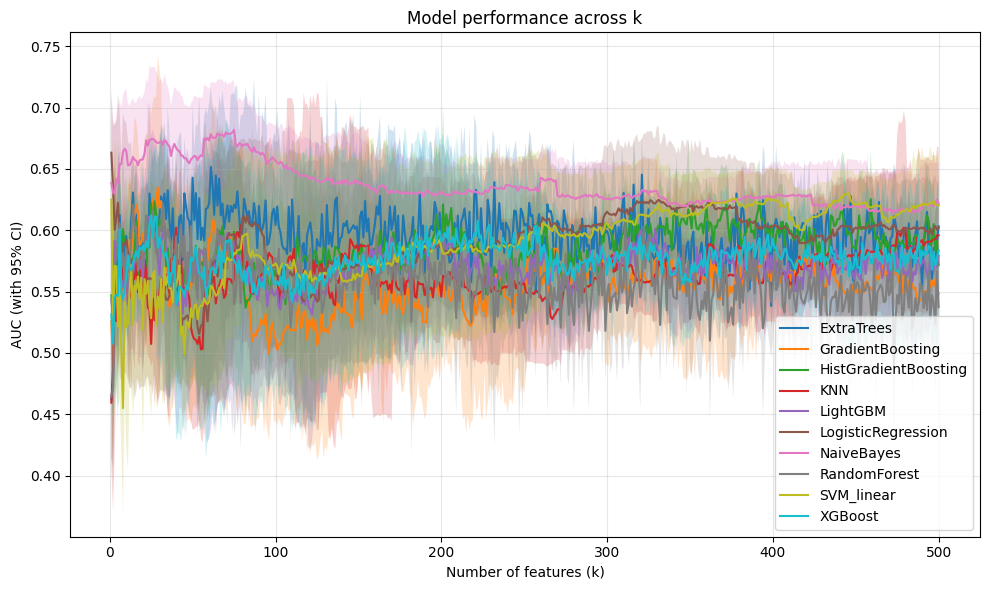

Saved: /home/77462217B/lois/AAImageneAnomalyDetection/results/betas/crossvalidation/Betas5ytd/auc_vs_k_with_ci.png
Saved: /home/77462217B/lois/AAImageneAnomalyDetection/results/betas/crossvalidation/Betas5ytd/summary_models.csv


,NaiveBayes,LogisticRegression,ExtraTrees,GradientBoosting,SVM_linear,HistGradientBoosting,RandomForest,LightGBM,XGBoost,KNN
Best AUC,0.6818,0.6633,0.6517,0.6349,0.6297,0.6254,0.6217,0.6147,0.6121,0.6038
Mean AUC,0.6361,0.5899,0.5960,0.5563,0.5904,0.5854,0.5588,0.5699,0.5760,0.5634


,NaiveBayes,LogisticRegression,ExtraTrees,GradientBoosting,SVM_linear,HistGradientBoosting,RandomForest,LightGBM,XGBoost,KNN
Best AUC,0.6818,0.6633,0.6517,0.6349,0.6297,0.6254,0.6217,0.6147,0.6121,0.6038
Mean AUC,0.6361,0.5899,0.5960,0.5563,0.5904,0.5854,0.5588,0.5699,0.5760,0.5634


Saved: /home/77462217B/lois/AAImageneAnomalyDetection/results/betas/crossvalidation/Betas5ytd/summary_table_colored.html


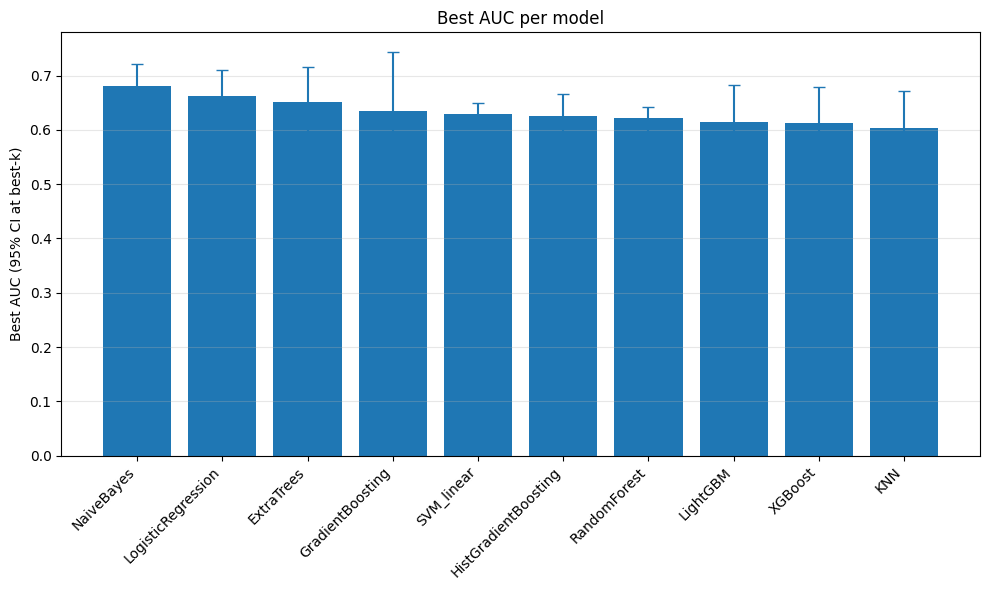

Saved: /home/77462217B/lois/AAImageneAnomalyDetection/results/betas/crossvalidation/Betas5ytd/best_auc_per_model_with_ci.png


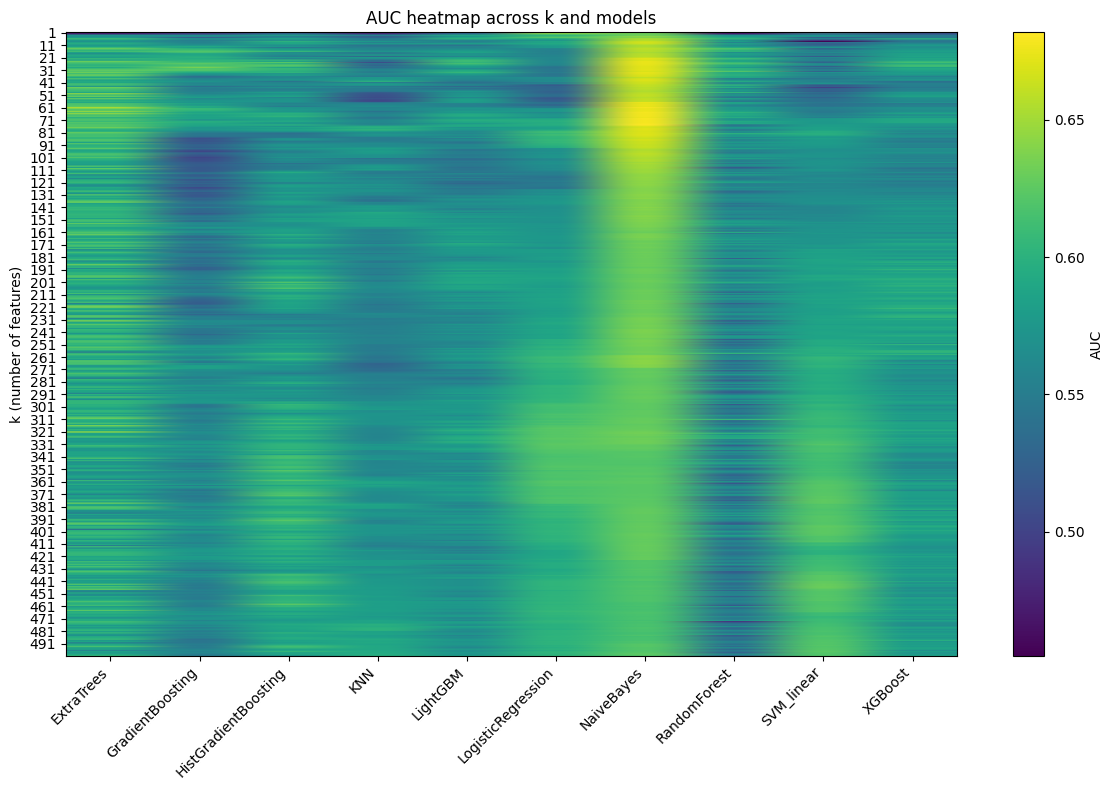

Saved: /home/77462217B/lois/AAImageneAnomalyDetection/results/betas/crossvalidation/Betas5ytd/auc_heatmap.png
Done.


In [13]:
visualize_cv_results("/home/77462217B/lois/AAImageneAnomalyDetection/results/betas/crossvalidation/Betas5ytd")